In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import math
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
from datasets import load_dataset

g:\UManitoba\DGM\Codes\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

In [6]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z = layers.Dense(latent_dim, name="z")(x)
encoder = keras.Model(encoder_inputs, z, name="encoder")
# encoder.summary()

In [7]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
# decoder.summary()

In [8]:
class AE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            total_loss = reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        }
    
    def call(self, inputs):
        z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

In [9]:
ae = AE(encoder, decoder)

# dummy = tf.zeros((2, 28, 28, 1))
# _ = ae(dummy)
ae.load_weights("model/P1T1_AE_mnist.weights.h5")

In [11]:
def mask_image(img, mask_size=12):
    img_masked = img.copy()
    
    H, W, _ = img.shape
    
    # Random top-left corner
    x = np.random.randint(0, H - mask_size)
    y = np.random.randint(0, W - mask_size)
    
    img_masked[x:x+mask_size, y:y+mask_size, :] = 0.0
    
    return img_masked

In [ ]:
num_samples = 10
indices = np.random.choice(len(mnist_digits), num_samples, replace=False)

originals = mnist_digits[indices]
masked = np.array([mask_image(img, mask_size=10) for img in originals])

reconstructed = ae.decoder.predict(ae.encoder.predict(masked))

1/1 [==============================] - 0s 373ms/step


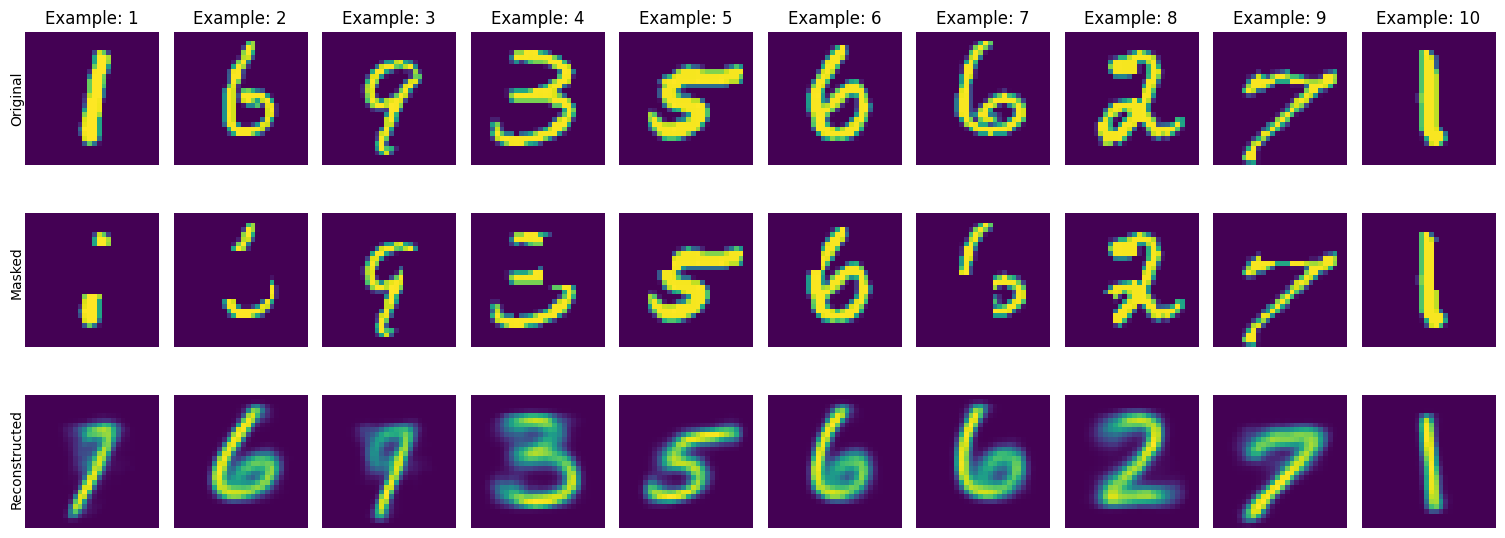

In [13]:
fig, axes = plt.subplots(3, num_samples, figsize=(15, 6))

for i in range(num_samples):
    # Original
    axes[0, i].imshow(originals[i])
    axes[0, i].set_title(f"Example: {i+1}")
    axes[0, i].axis("off")

    # Masked
    axes[1, i].imshow(masked[i])
    axes[1, i].axis("off")

    # Reconstructed
    axes[2, i].imshow(reconstructed[i])
    axes[2, i].axis("off")

fig.text(0.0, 0.8, "Original", va='center', rotation='vertical', fontsize=10)
fig.text(0.0, 0.51, "Masked", va='center', rotation='vertical', fontsize=10)
fig.text(0.0, 0.2, "Reconstructed", va='center', rotation='vertical', fontsize=10)

plt.tight_layout()
plt.show()
